# ResNet for tabular data

In [10]:
import comet_ml
from comet_ml import Experiment

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
import seaborn as sns

COMET_ML_API_KEY = ""
COMET_ML_PROJECT_NAME = "resnet-tabular"
COMET_ML_WORKSPACE = "nikolai-semenov"

## Data preparation

Sources:
1. https://archive.ics.uci.edu/ml/datasets/SUSY
1. https://archive.ics.uci.edu/ml/datasets/HIGGS

In [2]:
%%time
SUSY = pd.read_csv('data/SUSY.csv.gz', header=None)
HIGGS = pd.read_csv('data/HIGGS.csv.gz', header=None)

CPU times: user 2min 58s, sys: 2.89 s, total: 3min 1s
Wall time: 3min 1s


## Experiment preparation

View panel: https://www.comet.ml/nikolai-semenov/resnet-tabular/view/Iy69366eJvLEKY4yKNkqenI1j

In [3]:
def perform_experiment(
    model,
    X,
    y,
    test_size,
    batch_size,
    num_epochs,
    hyper_params={},
    log_every=100,
    random_state=42
):
    experiment = Experiment(
        api_key=COMET_ML_API_KEY,
        project_name=COMET_ML_PROJECT_NAME,
        workspace=COMET_ML_WORKSPACE,
    )
    if hyper_params:
        experiment.log_parameters(hyper_params)
    experiment.log_parameters({
        "test_size": test_size,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
    })
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    X_train = torch.Tensor(X_train)
    X_test = torch.Tensor(X_test)
    y_train = torch.Tensor(y_train)
    y_test = torch.Tensor(y_test)
    
    train_dataset = TensorDataset(X_train, y_train)    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))


    step = 0
    for epoch in tqdm(range(num_epochs), desc="Epoch", total=num_epochs):
        with experiment.train():
            model.train()
            for i, (x, y_true) in enumerate(train_loader):
                optimizer.zero_grad()
                y = model(x)
                loss = criterion(y, y_true)
                loss.backward()
                optimizer.step()
                
                step += 1  
                if step % log_every == 0:
                    experiment.log_metric("batch_loss", loss.item(), step=step, epoch=epoch)
            model.eval()
            with torch.no_grad():
                train_score = roc_auc_score(y_train.numpy(), model(X_train).numpy())
                experiment.log_metric("score", train_score, step=epoch, epoch=epoch)
        with experiment.test():
            model.eval()
            with torch.no_grad():
                test_score = roc_auc_score(y_test.numpy(), model(X_test).numpy())
                experiment.log_metric("score", test_score, step=epoch, epoch=epoch)
    experiment.end()

## Baseline

In [4]:
class BaselineModel(nn.Module):
    def __init__(self, input_size, n):
        super().__init__()
        self.baseline_model = nn.Sequential(
            nn.Linear(input_size, 8 * n),
            nn.LeakyReLU(negative_slope=1e-1),
            nn.Linear(8 * n, 6 * n),
            nn.LeakyReLU(negative_slope=1e-1),
            nn.Linear(6 * n, 4 * n),
            nn.LeakyReLU(negative_slope=1e-1),
            nn.Linear(4 * n, 3 * n),
            nn.LeakyReLU(negative_slope=1e-1),
            nn.Linear(3 * n, 2 * n),
            nn.LeakyReLU(negative_slope=1e-1),
            nn.Linear(2 * n, 1),
            nn.Sigmoid()
        )
        
        def init_weights(layer):
            if type(layer) == nn.Linear:
                nn.init.xavier_normal_(layer.weight, gain=1e-2)
        
        self.baseline_model.apply(init_weights)

    def forward(self, x):
        return self.baseline_model(x).reshape(-1)

## ResNet model

In [5]:
class ResNetUnit(nn.Module):
    def __init__(self, external_size, internal_size):
        super().__init__()
        self.unit = nn.Sequential(
            nn.Linear(external_size, internal_size),
            nn.LeakyReLU(negative_slope=1e-1),
            nn.Linear(internal_size, external_size),
            nn.LeakyReLU(negative_slope=1e-1),
        )
        
    def forward(self, x):
        return x + self.unit(x)

In [6]:
class ResNetSeq(nn.Module):
    def __init__(self, width, k_blocks):
        super().__init__()
        self.blocks = nn.Sequential(*[ResNetUnit(width, width // 2) for _ in range(k_blocks)])
    def forward(self, x):
        return self.blocks(x)

In [7]:
class ResNet(nn.Module):
    def __init__(self, input_size, n, k):
        super().__init__()
        widths = [input_size, 8 * n, 6 * n, 4 * n, 3 * n, 2 * n, 1]
        self.fc_layers = nn.ModuleList([nn.Linear(in_size, out_size) for (in_size, out_size) in zip(widths[:-1], widths[1:])])
        self.rn_layers = nn.ModuleList([ResNetSeq(width, k) for width in widths[1:-1]])
        self.activation = nn.LeakyReLU(negative_slope=1e-1)
        self.sigmoid = nn.Sigmoid()
        
        def init_fc(layer):
            if type(layer) == nn.Linear:
                nn.init.xavier_normal_(layer.weight, gain=1e-2)

        def init_rn(layer):
            if type(layer) == nn.Linear:
                nn.init.normal_(layer.weight, std=1e-3)

        self.fc_layers.apply(init_fc)
        self.rn_layers.apply(init_rn)
    
    def forward(self, x):
        for fc, rn in zip(self.fc_layers[:-1], self.rn_layers):
            x = rn(self.activation(fc(x)))
        return self.sigmoid(self.fc_layers[-1](x)).reshape(-1)

In [ ]:
for n in [24, 32, 48, 64]:
    for k in [1, 3, 4, 5, 8]:
        for test_size in [0.99]:
            perform_experiment(
                model=ResNet(SUSY.shape[1] - 1, n, k),
                X=SUSY.values[:,1:],
                y=SUSY.values[:,0],
                test_size=test_size,
                batch_size=2,
                num_epochs=100,
                hyper_params={
                    "model": "ResNet",
                    "dataset": "SUSY",
                    "n": n,
                    "k": k
                },
                log_every=100,
                random_state=42)

With greater `n` using ResNET layers results in gradient explosion :(

## Analysis

In [11]:
%%time
experiments = comet_ml.api.API(api_key=COMET_ML_API_KEY).get('nikolai-semenov/resnet-tabular')

parameters = ['model', 'dataset', 'test_size', 'n', 'k']
metrics = ['train_score', 'test_score']
dtypes = {
    'model': np.object,
    'dataset': np.object,
    'test_size': np.float,
    'n': np.int,
    'k': np.int,
    'train_score': np.float,
    'test_score': np.float
}
result = pd.DataFrame()

for parameter in parameters:
    result[parameter] = [experiment.get_parameters_summary(parameter)['valueCurrent'] if experiment.get_parameters_summary(parameter) else 0 for experiment in experiments]
for metric in metrics:
    result[metric] = [experiment.get_metrics_summary(metric)['valueMax'] if experiment.get_metrics_summary(metric) else np.nan for experiment in experiments]
result = result.dropna().reset_index().astype(dtypes)
result['train_size'] = 1 - result['test_size']
result = result[['model', 'dataset', 'train_size', 'test_size', 'n', 'k', 'train_score', 'test_score']]

CPU times: user 1.74 s, sys: 10.9 ms, total: 1.75 s
Wall time: 43.4 s


In [12]:
result

,model,dataset,train_size,test_size,n,k,train_score,test_score
0,baseline,SUSY,0.010,0.990,1,0,0.868341,0.869051
1,baseline,SUSY,0.010,0.990,4,0,0.873036,0.872055
2,baseline,SUSY,0.010,0.990,16,0,0.874455,0.872855
3,baseline,SUSY,0.100,0.900,1,0,0.863699,0.864306
4,baseline,SUSY,0.100,0.900,4,0,0.875218,0.875360
...,...,...,...,...,...,...,...,...
112,ResNet,SUSY,0.001,0.999,24,1,0.965852,0.864279
113,ResNet,SUSY,0.001,0.999,24,3,0.500000,0.500000
114,ResNet,SUSY,0.001,0.999,24,4,0.500000,0.500000
115,ResNet,SUSY,0.010,0.990,24,1,0.873653,0.871916


In [13]:
for dataset in result['dataset'].unique():
    print(f'{dataset}:')
    u = result[result['dataset'] == dataset]
    for train_size in sorted(u['train_size'].unique()):
        print(f'train_size={round(train_size, 4)}')
        t = u[u['train_size'] == train_size]
        t = t[t['test_score'] == t['test_score'].max()].iloc[0]
        print(f'n={t["n"]}')
        print(f'k={t["k"]}')
        print(f'test_score={t["test_score"]}')
        print()
    print()

SUSY:
train_size=0.001
n=12
k=3
test_score=0.8666860311767138

train_size=0.01
n=16
k=4
test_score=0.8729948475576247

train_size=0.05
n=32
k=0
test_score=0.8756468786345084

train_size=0.1
n=16
k=0
test_score=0.8764915101682792

train_size=0.5
n=16
k=0
test_score=0.8776477339370397


HIGGS:
train_size=0.001
n=16
k=0
test_score=0.7195656454185656

train_size=0.01
n=4
k=4
test_score=0.8070585497138671

train_size=0.05
n=8
k=0
test_score=0.836219516064709

train_size=0.1
n=16
k=0
test_score=0.8465206299455973




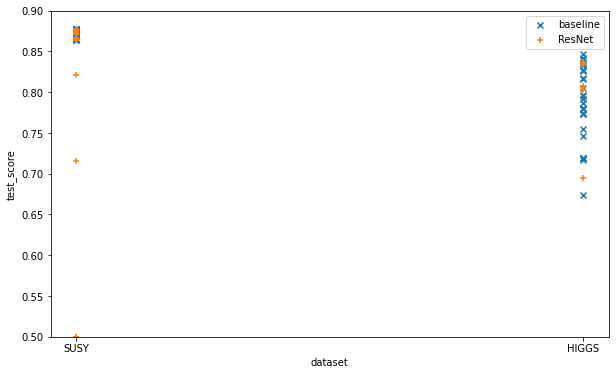

In [14]:
plt.figure(figsize=(10, 6))
plt.xlabel('dataset')
plt.ylim(0.5, 0.9)
plt.ylabel('test_score')
for i, model in enumerate(result['model'].unique()):
    t = result[result['model'] == model]
    if t.shape[0] > 0:
        plt.scatter(t['dataset'], t['test_score'], marker='x+'[i], label=f'{model}')
plt.legend()

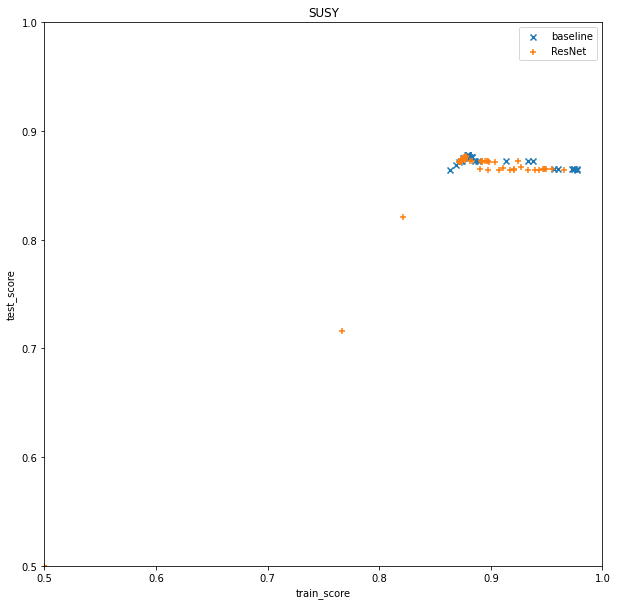

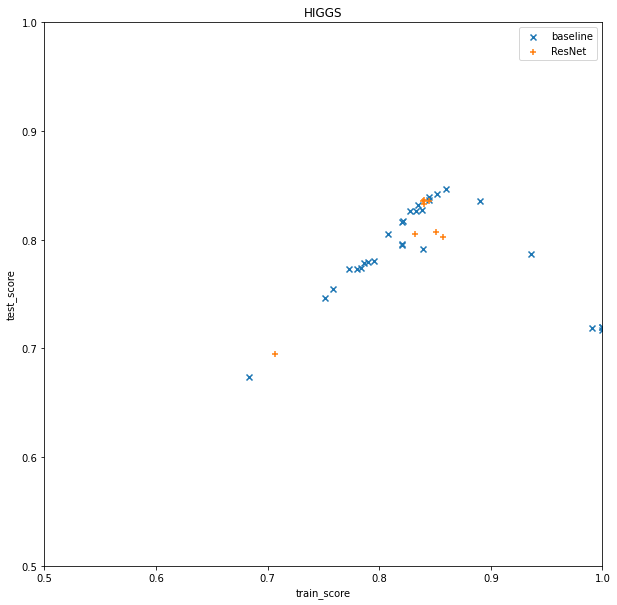

In [15]:
for dataset in result['dataset'].unique():
    plt.figure(figsize=(10, 10))
    plt.xlim(0.5, 1)
    plt.xlabel('train_score')
    plt.ylim(0.5, 1)
    plt.ylabel('test_score')
    plt.title(dataset)
    for i, model in enumerate(result['model'].unique()):
        t = result[(result['dataset'] == dataset) & (result['model'] == model)]
        if t.shape[0] > 0:
            plt.scatter(t['train_score'], t['test_score'], marker='x+'[i], label=f'{model}')
    plt.legend()

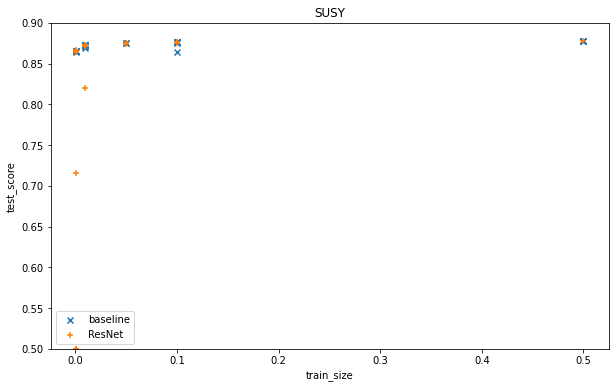

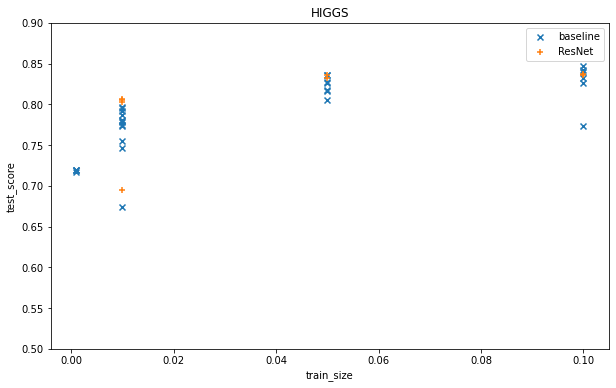

In [16]:
for dataset in result['dataset'].unique():
    plt.figure(figsize=(10, 6))
    plt.xlabel('train_size')
    plt.ylim(0.5, 0.9)
    plt.ylabel('test_score')
    plt.title(dataset)
    for i, model in enumerate(result['model'].unique()):
        t = result[(result['dataset'] == dataset) & (result['model'] == model)]
        if t.shape[0] > 0:
            plt.scatter(t['train_size'], t['test_score'], marker='x+'[i], label=f'{model}')
    plt.legend()

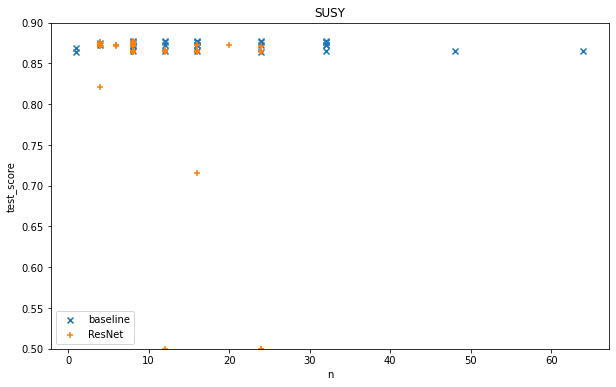

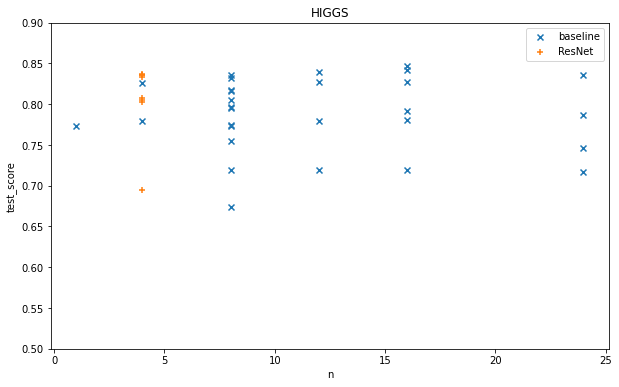

In [18]:
for dataset in result['dataset'].unique():
    plt.figure(figsize=(10, 6))
    plt.xlabel('n')
    plt.ylim(0.5, 0.9)
    plt.ylabel('test_score')
    plt.title(dataset)
    for i, model in enumerate(result['model'].unique()):
        t = result[(result['dataset'] == dataset) & (result['model'] == model)]
        if t.shape[0] > 0:
            plt.scatter(t['n'], t['test_score'], marker='x+'[i], label=f'{model}')
    plt.legend()

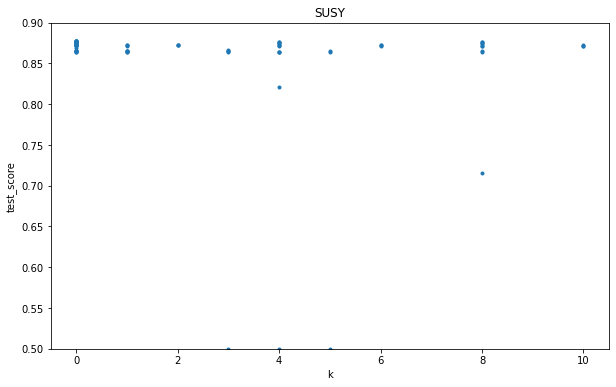

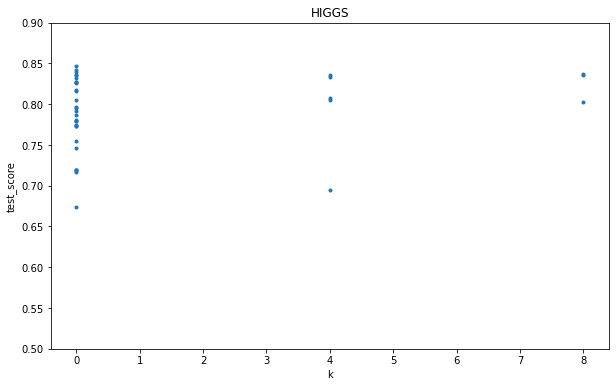

In [19]:
for dataset in result['dataset'].unique():
    plt.figure(figsize=(10, 6))
    plt.xlabel('k')
    plt.ylim(0.5, 0.9)
    plt.ylabel('test_score')
    plt.title(dataset)
    t = result[result['dataset'] == dataset]
    plt.scatter(t['k'], t['test_score'], marker='.')

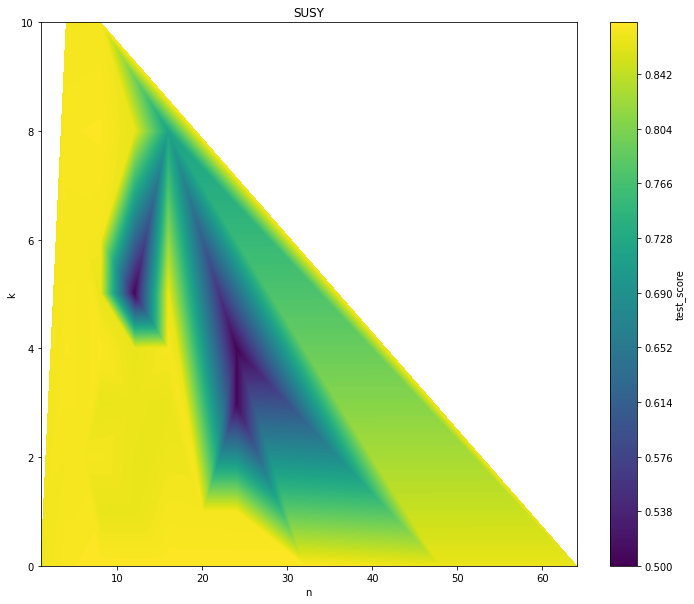

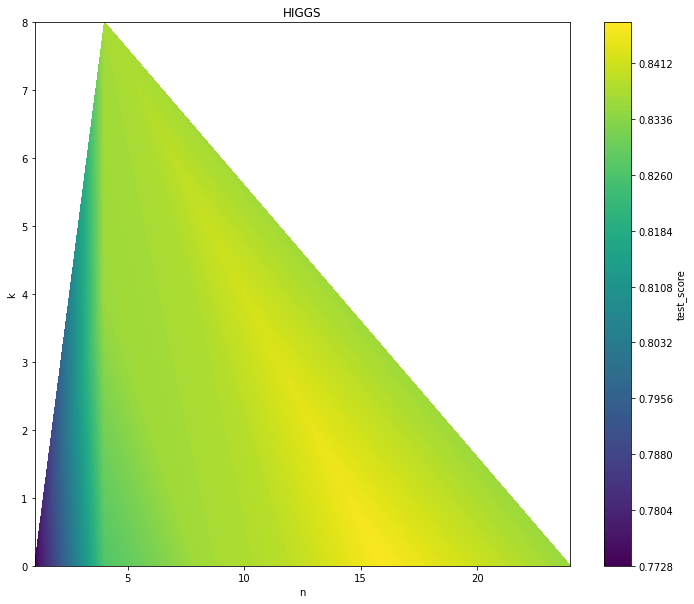

In [20]:
for dataset in result['dataset'].unique():
    plt.figure(figsize=(12, 10))
    plt.xlabel('n')
    plt.ylabel('k')
    plt.title(dataset)
    t = result[result['dataset'] == dataset].groupby(['n', 'k']).max()
    plt.tricontourf(t.index.get_level_values(0), t.index.get_level_values(1), t['test_score'], levels=200)
    plt.colorbar().set_label('test_score')